In [60]:
import json 
import numpy as np
import thermocore.io.casm as cio
from djlib.plotting.hull_plotting import general_binary_convex_hull_plotter
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoLarsCV
import thermocore.geometry.hull as thull
import djlib.clex.clex as cl
import os
import pickle
from sklearn.metrics import mean_squared_error

In [61]:
#Load the query data from the json file
with open('ZrN_FCC_1.2.0_TITAN_calculated.json') as f:
    query = json.load(f)
data = cio.regroup_query_by_config_property(query)
corr = np.array(data['corr'])
corr_unaltered = np.array(data['corr'])
comp = np.array(data['comp'])
formation_energy = np.array(data['formation_energy'])
name = np.array(data['name'])
print(corr.shape)


(1297, 1335)


In [62]:
#Often, we will work with a large set of basis functions, and remove basis functions that are not needed. 
#However, CASM will expect an ECI vector that is the same length as the original set of basis functions.
#Maintaining an upscaling vector of booleans allows us to record the basis functions that are removed, and
#reconstruct the original ECI vector when needed.
upscaling_boolean_vector = np.array([True]*corr.shape[1])

In [63]:
#Dealing with a CASM bug: large clusters with multiplicity ==1 produce problems in monte carlo. Remove them from the fit.


#Load the basis.json file to find the multiplicity of each correlation
#Normally, this is located in project_root/basis_sets/bset.default/basis.json
basis_path = './basis.json'
with open(basis_path) as f:
    basis = json.load(f)
multiplicities = np.array(cio.pull_multiplicity_from_json(basis))
print(np.where(multiplicities == 1))

#Current bug in casm: large clusters with multiplicity ==1 produce problems in monte carlo. 
#Find clusters with multiplicity == 1; if the index is greater than 10, remove, store that index
large_multiplicity_1_clusters = np.where(multiplicities == 1)[0]
large_multiplicity_1_clusters = large_multiplicity_1_clusters[large_multiplicity_1_clusters > 10]
print(large_multiplicity_1_clusters)

#Remove clusters with multiplicity == 1 and index > 10 from corr
upscaling_boolean_vector[large_multiplicity_1_clusters] = False
print(upscaling_boolean_vector.shape)
print(corr.shape)
corr = corr[:,upscaling_boolean_vector]
print(corr.shape)

print('\nLarge clusters with multiplicity == 1 have been removed from corr.')

(array([  0,   1, 605]),)
[605]
(1335,)
(1297, 1335)
(1297, 1334)

Large clusters with multiplicity == 1 have been removed from corr.


In [64]:
#Load the fully enumerated data:
with open('ZrN_FCC_1.2.0_TITAN_67k_uncalculated_3-15-2023.json') as f:
    query = json.load(f)
data = cio.regroup_query_by_config_property(query)
corr_full = np.array(data['corr'])
corr_full_unaltered = np.array(data['corr'])
comp_full = np.array(data['comp'])
name_full = np.array(data['name'])

print(corr_full.shape)

#Remove large clusters with multiplicity == 1 from corr_full
corr_full = corr_full[:,upscaling_boolean_vector]
print(corr_full.shape)



(69964, 1335)
(69964, 1334)


In [65]:
#To find models that replicate DFT ground states, we need to identify the DFT ground states. 
#Additionally, if we want to prioritize models that are close to the convex hull, we need to quantify the distance of each model from the convex hull.
#Hull distances are used for weighted least squares, but they are also used for calculating hull distance correlations. 


#Calculate hull distances for each point
hull = thull.full_hull(compositions=comp, energies=formation_energy)
hull_distances = thull.lower_hull_distances(convex_hull=hull, compositions=comp, energies=formation_energy)

#Calculate true convex hull vertices
true_lower_hull_vertices, _ = thull.lower_hull(hull)
print(true_lower_hull_vertices)
print(comp[true_lower_hull_vertices])
print(name[true_lower_hull_vertices])

#Calculate hull distance correlations
hull_corr = thull.hull_distance_correlations(corr=corr, compositions=comp, formation_energy=formation_energy, hull=hull)
feature_matrix = np.concatenate((corr, hull_corr), axis=0)
target_values = np.concatenate((formation_energy, hull_distances), axis=0)

[   0    1   27   28  863 1052 1058 1076]
[[1.        ]
 [0.        ]
 [0.5       ]
 [0.25      ]
 [0.81818182]
 [0.85714286]
 [0.78571429]
 [0.71428571]]
['SCEL1_1_1_1_0_0_0/0' 'SCEL1_1_1_1_0_0_0/1' 'SCEL4_4_1_1_0_2_1/1'
 'SCEL4_4_1_1_0_2_1/2' 'SCEL11_11_1_1_0_8_5/1' 'SCEL14_7_2_1_0_3_5/0'
 'SCEL14_7_2_1_0_3_5/6' 'SCEL14_7_2_1_1_3_6/2']


In [66]:
#The fully enumerated dataset contains all calculated and uncalculated structures. 
#However, the same structures may have different indices in the calculated and uncalculated datasets.
#We know the hull vertex indices in the calculated dataset; find their corresponding index in the uncalculated dataset.

#The correlation vector for a structure is the same in both the calculated and uncalculated datasets.
#Therefore, we can use the correlation vector to find the index of the hull vertex in the uncalculated dataset.

#Find the correlation vector for each hull vertex in the calculated dataset
hull_vertices_corr = corr[true_lower_hull_vertices,:]
print(hull_vertices_corr.shape)

#Find the index of each hull vertex in the uncalculated dataset
hull_vertex_indices_full_enumeration = []
for i in range(hull_vertices_corr.shape[0]):
    hull_vertex_indices_full_enumeration.append(np.where((corr_full == hull_vertices_corr[i]).all(axis=1))[0][0])
hull_vertex_indices_full_enumeration = np.array(hull_vertex_indices_full_enumeration)
print(name_full[hull_vertex_indices_full_enumeration])


(8, 1334)
['SCEL1_1_1_1_0_0_0/0' 'SCEL1_1_1_1_0_0_0/1' 'SCEL4_4_1_1_0_2_1/1'
 'SCEL4_4_1_1_0_2_1/2' 'SCEL11_11_1_1_0_8_5/1' 'SCEL14_7_2_1_0_3_5/0'
 'SCEL14_7_2_1_0_3_5/6' 'SCEL14_7_2_1_1_3_6/2']


In [67]:
#Build the model that we will use to fit the data.
reg = LassoLarsCV(fit_intercept=False, n_jobs=-1, max_iter=50000)

#Weighted leas squares requires a weighting scheme. We will weight by the Boltzmann distribution of the hull distances.
#We must still specify how "aggressively" we want to weight the data. This is done by specifying a "B" value.
#Larger B values will weight the data more aggressively, placing more emphasis on data that is close to the convex hull.
#Specify an array of boltzmann "B" weights to use: linearly spaced from 1 to 300, 100 points
B = np.linspace(1, 300, 500)


In [ ]:
#For each B, calculate the weighted feature and target arrays. 
#Then fit a cluster expansion model with LassoLarsCV
models = []
for b in B:
    #calculate the weighted feature and target vectors
    weight = np.identity(target_values.shape[0])
    for config_index in range(formation_energy.shape[0]):
        weight[config_index, config_index] = cl.boltzmann(
            hulldist=hull_distances[config_index], coef=1, beta=b, temperature=1.05
        )
        weight[config_index+formation_energy.shape[0], config_index+formation_energy.shape[0]] = cl.boltzmann(
            hulldist=hull_distances[config_index], coef=1, beta=b, temperature=1.05
        )
    x_prime, y_prime = cl.general_weighted_feature_and_target_arrays(feature_matrix=feature_matrix, target_array=target_values, weight_matrix=weight)
    
    #fit the model
    reg.fit(x_prime, y_prime)
    models.append(reg.coef_)

models = np.array(models)
print(models.shape)

In [ ]:
#dump the models to a pickle file, just so that we don't have to do this every time we open the notebook.
print(models.shape)
with open('weighted_LassoLarsCV_models.json', 'w') as f:
    json.dump({'models':models.tolist()}, f) 

In [68]:
#Load models from the pickle file
with open('weighted_LassoLarsCV_models.json', 'r') as f:
    models = np.array(json.load(f)['models'])
print(models.shape)
    

(500, 1334)


In [69]:
#Calculate the predicted energies for each model 
predicted_energies = corr @ models.T
predicted_energies = predicted_energies.T

predicted_energies_full_enumeration = corr_full @ models.T
predicted_energies_full_enumeration = predicted_energies_full_enumeration.T

print(predicted_energies.shape)
print(predicted_energies_full_enumeration.shape)

(500, 1297)
(500, 69964)


In [70]:
#For each row in the predicted energies array, compute: 
#rmse, ground_state_accuracy_metric, ground_state_fraction_correct, gsa_fraction_correct_DFT_mu_window_binary, gsa_intersection_over_union, complexity

max_rmse_tolerance = 0.030 #eV/prim

rmse = []
gsad = []
fraction_correct_weighted_full_enumeration = []
complexity = []

for index, row in enumerate(predicted_energies):
    #calculate predicted ground state indices
    predicted_hull = thull.full_hull(compositions=comp, energies=row)
    predicted_lower_hull_vertices, _ = thull.lower_hull(predicted_hull)

    #calculate the rmse
    rmse.append(np.sqrt(mean_squared_error(formation_energy, row)))

    #calculate the ground state accuracy metric with a DFT mu window
    gsad.append(
        cl.gsa_fraction_correct_DFT_mu_window_binary(predicted_comp=comp,
                                                     predicted_energies=row,
                                                     predicted_corr=corr, 
                                                     true_comp=comp, 
                                                     true_energies=formation_energy,
                                                     true_corr=corr)
        )
    
    #calculate the model complexity: number of nonzero ECI
    complexity.append(np.count_nonzero(models[index,:])/len(models[index,:]))

rmse = np.array(rmse)
gsad = np.array(gsad)
complexity = np.array(complexity)


for index, row in enumerate(predicted_energies_full_enumeration):
    predicted_hull_full_enumeration = thull.full_hull(compositions=comp_full, energies=row)
    predicted_lower_hull_vertices_full_enumeration, _ = thull.lower_hull(predicted_hull_full_enumeration)

    fraction_correct_weighted_full_enumeration.append(
        cl.gsa_fraction_correct_DFT_mu_window_binary(predicted_comp=comp_full, 
                                                     predicted_energies=row,
                                                     predicted_corr=corr_full,
                                                     true_comp=comp,
                                                     true_energies=formation_energy,
                                                     true_corr=corr)
        )
fraction_correct_weighted_full_enumeration = np.array(fraction_correct_weighted_full_enumeration)


Max error:  0.03584708075785629  eV


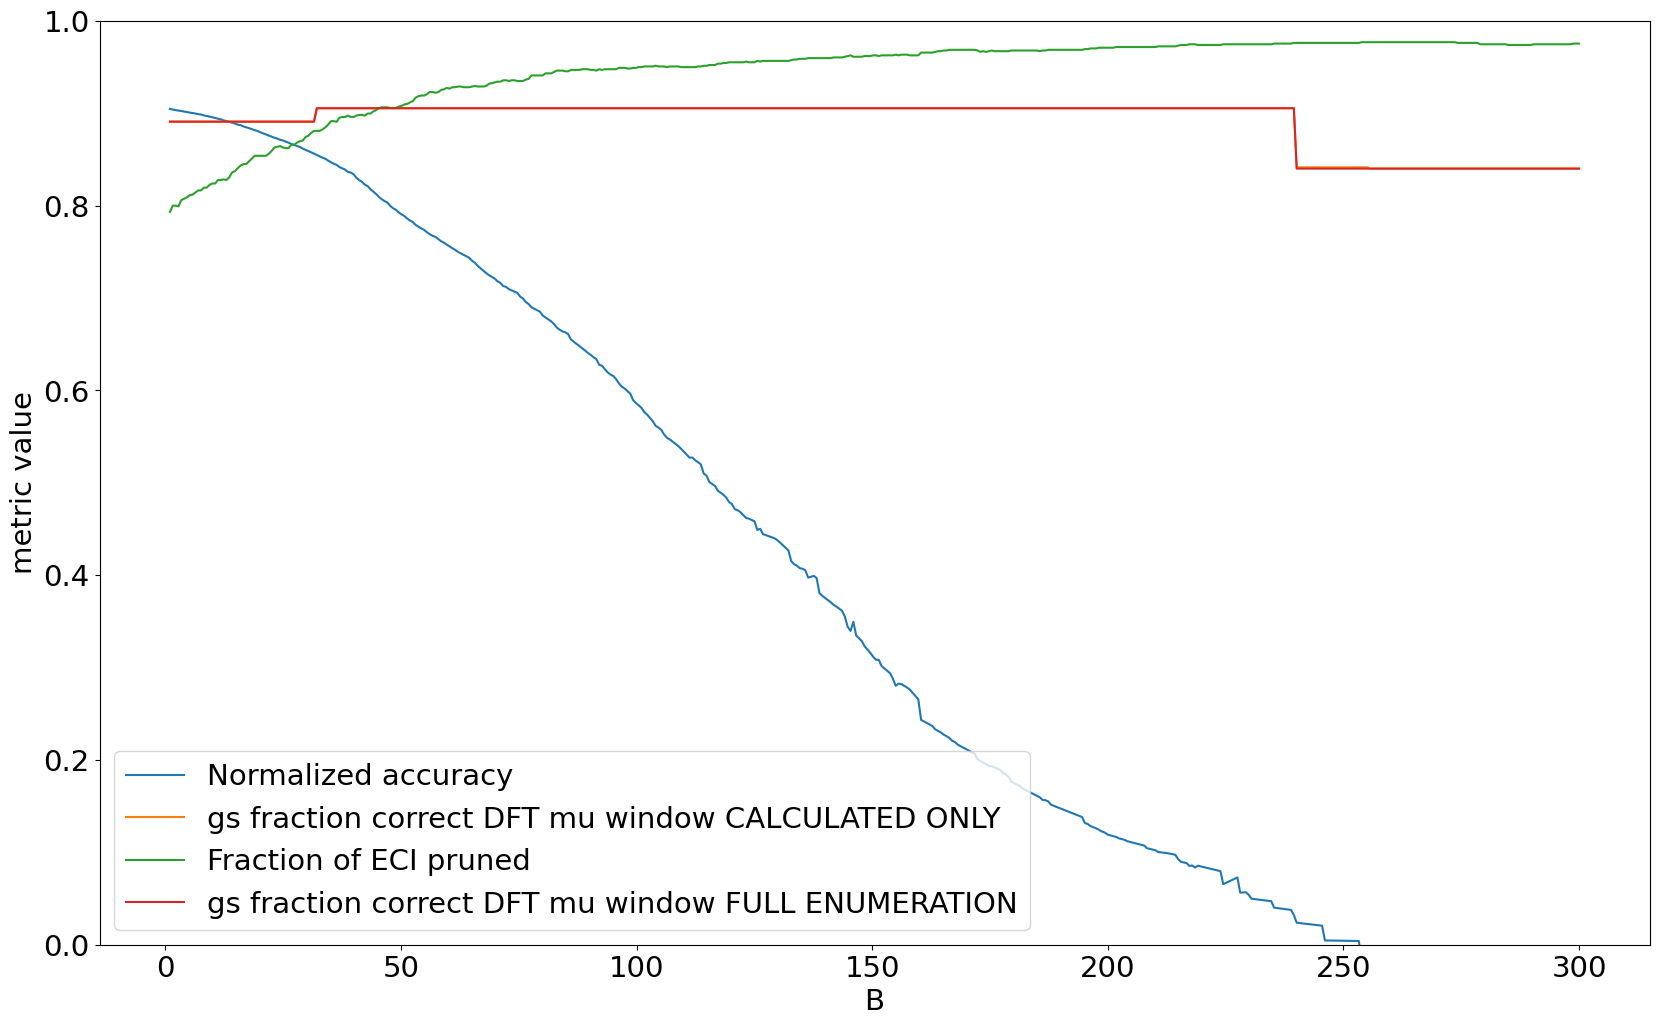

In [71]:
#Plot all metrics vs B


fig, ax = plt.subplots(1, 1, figsize=(20, 12))
print('Max error: ', max(rmse),' eV')


ax.plot(B, 1-np.array(rmse)/max_rmse_tolerance, label='Normalized accuracy')
ax.plot(B, gsad, label='gs fraction correct DFT mu window CALCULATED ONLY')
ax.plot(B, 1-np.array(complexity), label='Fraction of ECI pruned')
ax.plot(B, fraction_correct_weighted_full_enumeration, label='gs fraction correct DFT mu window FULL ENUMERATION')



ax.set_xlabel('B', fontsize=21)
ax.set_ylabel('metric value', fontsize=21)
ax.legend(fontsize=21)
plt.ylim([0,1])
plt.xticks(fontsize=21)
plt.yticks(fontsize=21)

plt.show()

57 0.6833486056138522


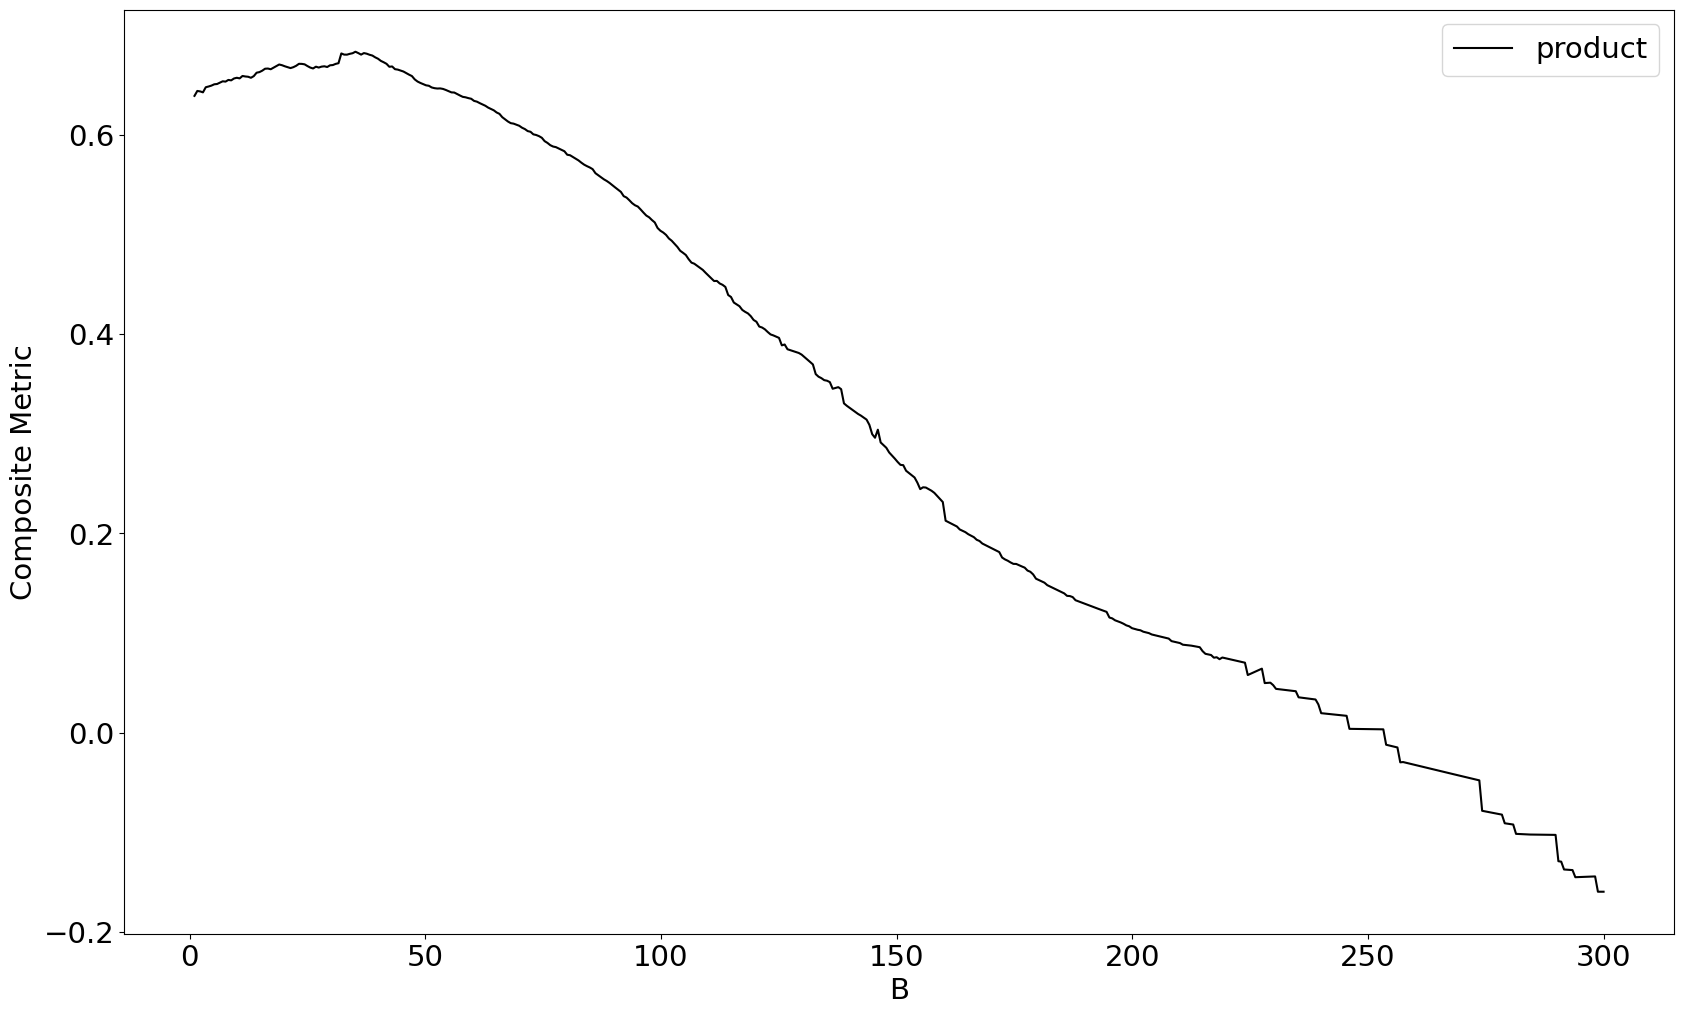

In [72]:
#We are primarily interested in four metrics:
#1. Fraction correct, weighted by stable chemical potential window. This is labelled 'gsad' in the dataframe.
#2. Intersection over union, weighted by stable chemical potential window. This is labelled 'gsa' in the dataframe.
#3. Normalized accuracy.
#4. Fraction of ECI pruned.
#All of these metrics are normalized [0,1], where 1 is the best possible value.
#Create a composite metric by multiplying some, or all metrics together, and then plot the result vs B.

product = fraction_correct_weighted_full_enumeration * (1-np.array(rmse)/max_rmse_tolerance) * (1-np.array(complexity))

print(np.argmax(product), max(product))
fig, ax = plt.subplots(1, 1, figsize=(20, 12))
ax.plot(B, product, label='product', color='k')
ax.set_xlabel('B', fontsize=21)
ax.set_ylabel('Composite Metric', fontsize=21)
plt.xticks(fontsize=21)
plt.yticks(fontsize=21)
ax.legend(fontsize=21)
plt.show()

In [73]:
#find the  maximum value of the combined metric and the corresponding B

max_index = np.argmax(product)
max_value = max(product)
max_B = B[max_index]


print(max_value, max_B, max_index)


#Rank the modls by the combined metric: print the indices of the top 10 models, just in case you want to look at them.
for i in np.argsort(product)[::-1][:10]:
    print(i, product[i])


0.6833486056138522 35.15430861723447 57
57 0.6833486056138522
58 0.6819986555675689
60 0.6819779914825277
56 0.6818491312048641
52 0.6816282417282311
61 0.681368967311787
55 0.6812385839218719
53 0.6804542902129158
59 0.680451715239222
54 0.6804051380959716


In [74]:
#Find the model with the maximum value of the combined metric
max_model = models[max_index]

#Add a manual override for the maximum index, in case you want to look at a specific model
manual_max_index = False #0
if manual_max_index is not False:
    max_model = models[manual_max_index]
    max_index = manual_max_index

print(max_model.shape)

#Write the max model to a file
with open('max_model.json', 'w') as f:
    json.dump({'max_model':max_model.tolist(), 'upscaling_vector':upscaling_boolean_vector.tolist()}, f)
    


(1334,)


There are 145 non-zero coefficients in the model
145
0.905293590875201


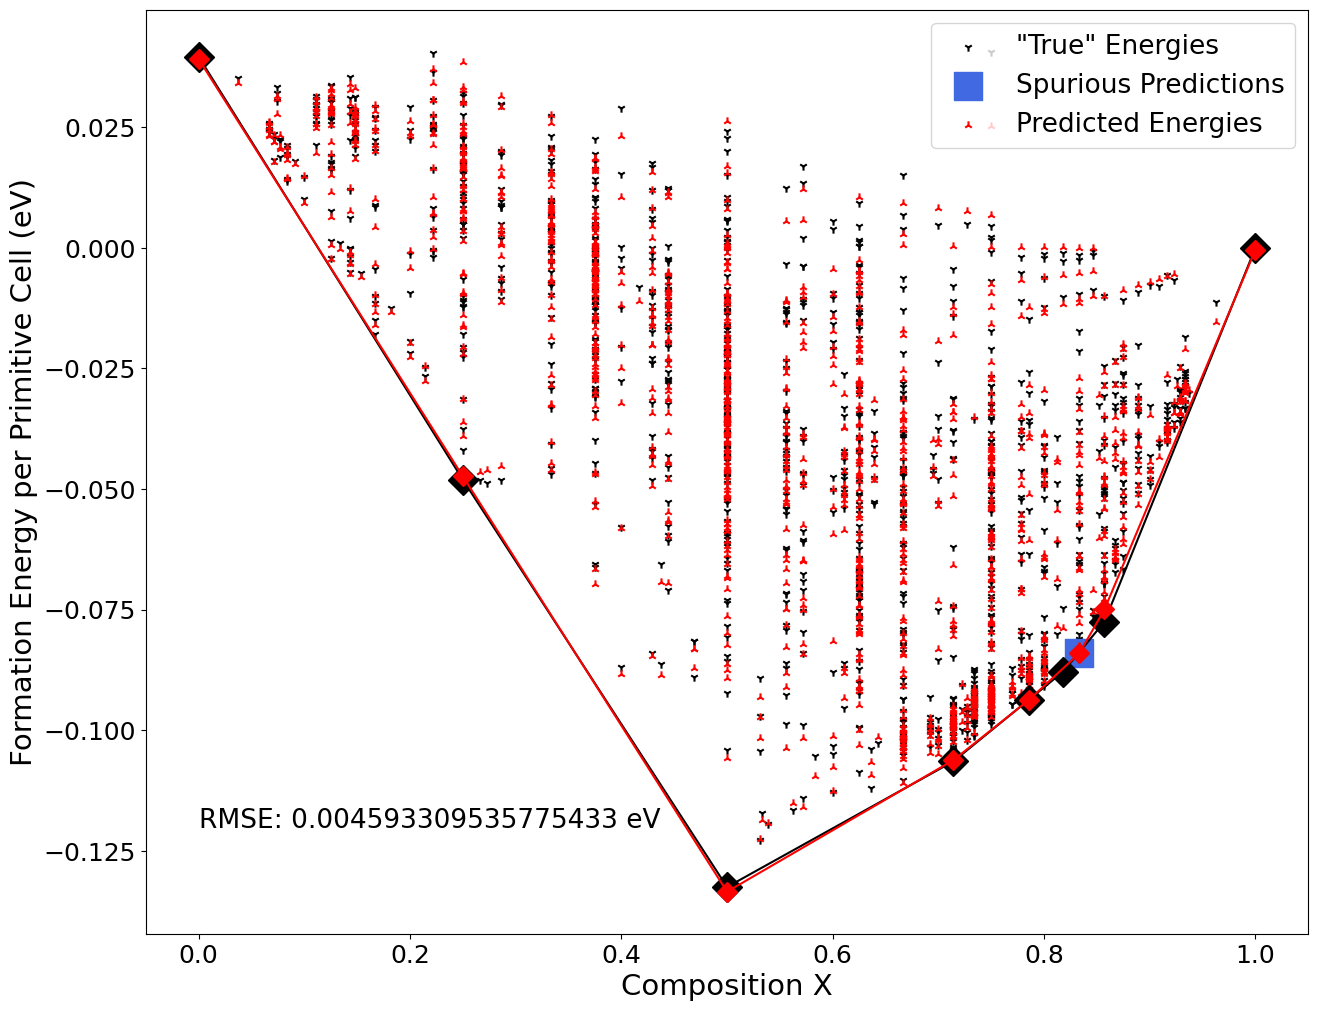

In [75]:
#Visualize the optimal model
print('There are {} non-zero coefficients in the model'.format(np.count_nonzero(max_model)))
from djlib.plotting.hull_plotting import general_binary_convex_hull_plotter

print(np.count_nonzero(max_model))



print(cl.gsa_fraction_correct_DFT_mu_window_binary(predicted_comp=comp_full.reshape(-1,1),
                                                   predicted_energies=np.ravel(predicted_energies_full_enumeration[max_index]), 
                                                   predicted_corr=corr_full,
                                                   true_comp=comp.reshape(-1,1),
                                                   true_energies= np.ravel(formation_energy),
                                                   true_corr=corr)
                                                   )

fig = general_binary_convex_hull_plotter(comp, formation_energy, predicted_energies=predicted_energies[max_index])
fig.set_size_inches(15,12)
plt.show()

dict_keys(['bspecs', 'orbits', 'prim', 'site_functions'])
[]
[0 1 2 ... 8 8 8]
[   0    1   24  240  353  604 1195 1276]


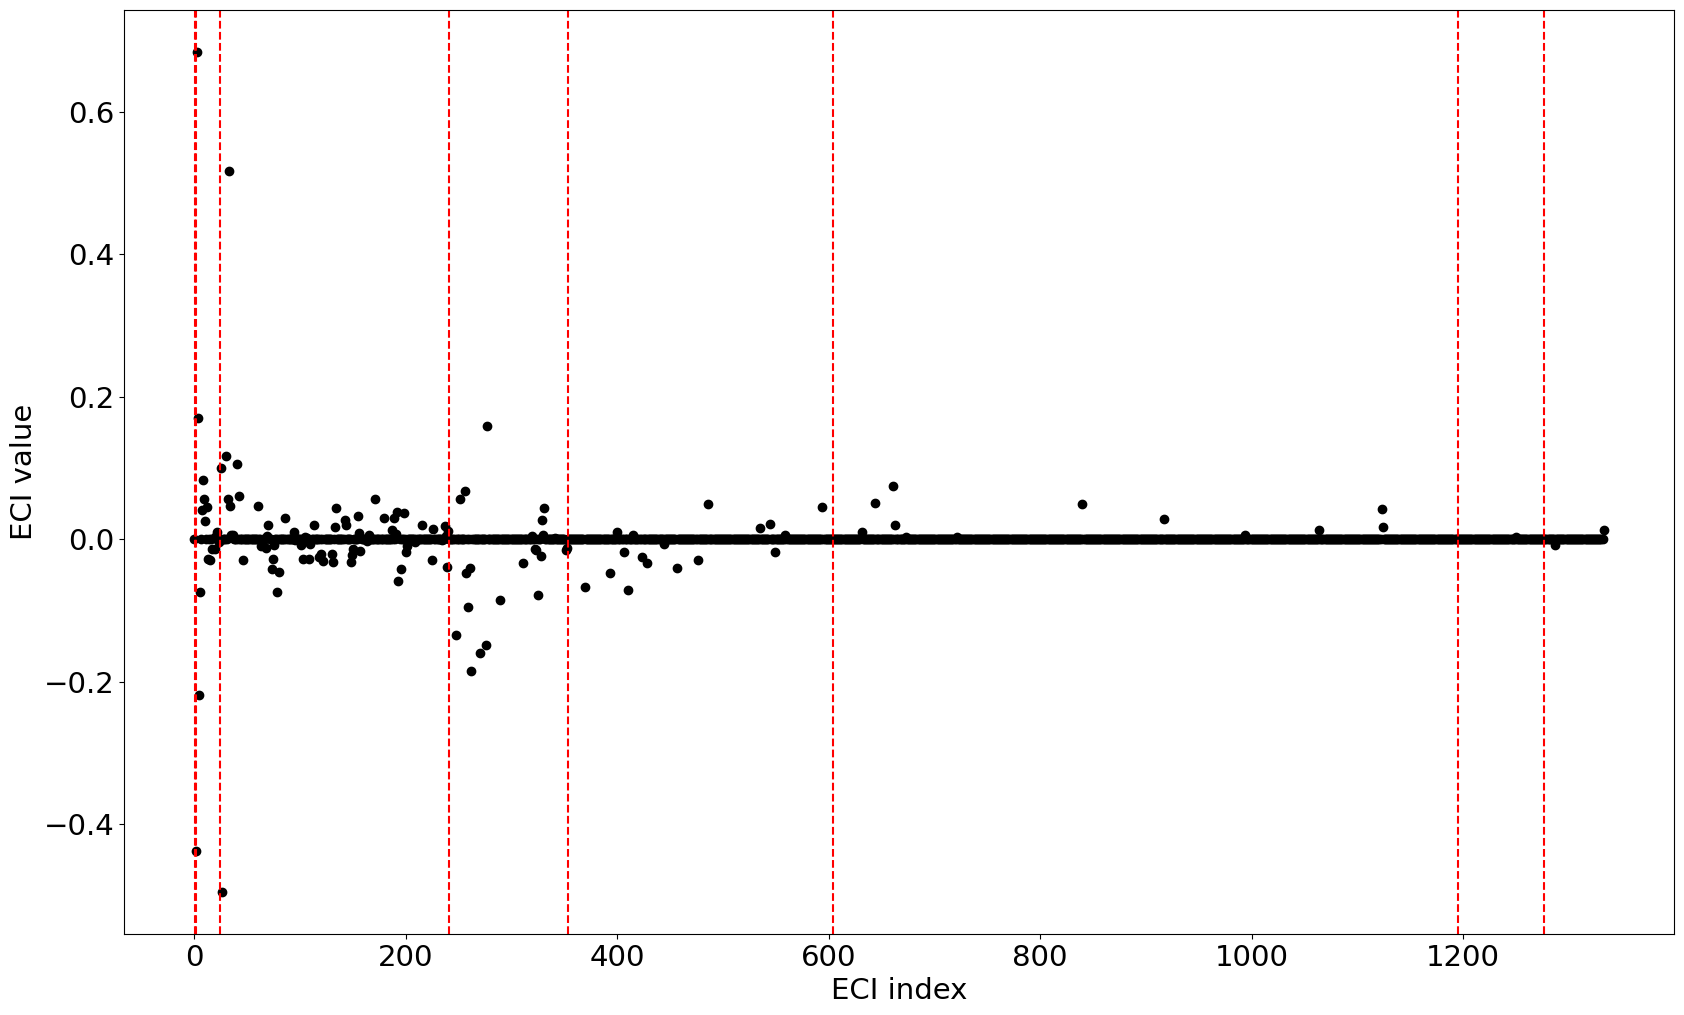

In [77]:
#Visualize the ECI of the optimal model
#The plot is divided by vertical dashed red lines, denoting the empty, point, pair, triplet, etc. clusters. 


#load the basis.json file to access site multiplicity in each cluster
with open('basis.json', 'r') as f:
    basis = json.load(f)
print(basis.keys())
print(basis['orbits'][0]['prototype']['sites'])

cluster_sizes = np.array([len(basis['orbits'][i]['prototype']['sites']) for i in range(len(basis['orbits']))])
print(cluster_sizes)

#find the indices where the cluster size increments by 1
cluster_size_indices = np.where(np.diff(cluster_sizes)==1)[0]
print(cluster_size_indices)


plt.scatter(list(range(max_model.shape[0])), max_model, color='k')
fig = plt.gcf()
fig.set_size_inches(20, 12)
plt.xticks(fontsize=21)
plt.yticks(fontsize=21)
plt.xlabel('ECI index', fontsize=21)
plt.ylabel('ECI value', fontsize=21)
#Plot a vertical dashed line at each cluster size increment
for i in cluster_size_indices:
    plt.axvline(x=i+.5, color='r', linestyle='--')
plt.show()

In [93]:
#Once a prior mean is decided, a prior standard deviation must be chosen.  
import djlib.djlib as dj
eci_stddev_values = np.linspace(0.00001, 0.05, 100)         #stddev in eV
prior_mean = max_model
likelihood_stddev = 0.005                               #stddev in eV

#Collect all indices of nonzero coefficients and store them in an array called nonzero_indices
#The prior mean must first be upscaled back to the original feature size (because of the casm bug)
full_dimension_prior_mean = cio.upscale_eci_vector(prior_mean, upscaling_boolean_vector)
print(full_dimension_prior_mean.shape)

(1335,)


In [94]:
#Find the coefficient indices that have been pruned. Store them to allow later upscaling
zero_indices = np.where(full_dimension_prior_mean == 0)[0]
zeroed_upscaling_boolean_vector = np.copy(upscaling_boolean_vector)
zeroed_upscaling_boolean_vector[zero_indices] = False


#downsample the correlation matrix to only include nonzero coefficients
corr_nonzero = corr_unaltered[:, np.where(zeroed_upscaling_boolean_vector)[0]]
corr_full_nonzero = corr_full_unaltered[:, np.where(zeroed_upscaling_boolean_vector)[0]]
print(corr_nonzero.shape)
print(corr_full_nonzero.shape)

#downsample the prior mean to only include nonzero coefficients
prior_mean_nonzero = full_dimension_prior_mean[np.where(zeroed_upscaling_boolean_vector)[0]]
print(prior_mean_nonzero.shape)

(1297, 145)
(69964, 145)
(145,)


In [108]:
#There are multiple ways to choose the prior standard deviation. 
#One way is to start the prior at the prior mean, and iteratively broaden the standard deviaiton, 
#monitoring the ground state accuracy as the prior distribution is broadened. 



#It is sometimes possible for this sampling to find a model with a better ground state accuracy. 
#If the "prior_data" pkl file exists, load it and use the max_gsa_model as the new prior_mean_nonzero

if os.path.exists('prior_data.pkl'):
    with open('prior_data.pkl', 'rb') as f:
        prior_data = pickle.load(f)
    prior_mean_nonzero = prior_data['max_gsa_model']
    print(prior_mean_nonzero.shape)
    print(prior_mean_nonzero)
    print('Loaded prior data from prior_data.pkl')

#For each value of the prior variance, define a prior covariance matrix as the identity matrix multiplied by the variance.
prior_data = {"rmse_means":[],"rmse_stddevs":[], "fraction_correct_weighted_means":[],"fraction_correct_weighted_stddevs":[] }


#Store the model with the maximum ground state accuracy; every sample, check if the current model has a higher ground state accuracy than the previous maximum. 
# If so, replace the previous model with the current model.
max_gsa = 0
max_gsa_model = None

for index, eci_stddev in enumerate(eci_stddev_values):
    prior_covariance = eci_stddev ** 2 * np.identity(prior_mean_nonzero.shape[0])
    
    #Sample from the prior distribution using the prior mean and covariance matrix; take 1000 samples
    prior_samples = np.random.multivariate_normal(prior_mean_nonzero, prior_covariance, 10000)

    #For each sample, calculate the rmse and ground state accuracy of the model
    predicted_energies = corr_nonzero @ prior_samples.T
    predicted_energies_full = corr_full_nonzero @ prior_samples.T
    
    #Calculate the rmse and ground state accuracy of each model
    rmse = [mean_squared_error(formation_energy, predicted_energy, squared=False) for predicted_energy in predicted_energies.T]
    fraction_correct = [cl.gsa_fraction_correct_DFT_mu_window_binary(predicted_comp=comp_full,
                                                                    predicted_energies=predicted_energy_full_vec, 
                                                                    predicted_corr=corr_full_nonzero,
                                                                    true_comp=comp,
                                                                    true_energies=formation_energy,
                                                                    true_corr=corr_nonzero
                                                                    ) for predicted_energy_full_vec in predicted_energies_full.T
                                                                    ]

    #Check the ground state accuracy of the current model. If it is higher than the previous maximum, replace the previous maximum with the current model.
    if max(fraction_correct) > max_gsa:
        max_gsa = max(fraction_correct)
        max_gsa_model = prior_samples[np.argmax(fraction_correct)]
        max_index = index
        prior_data["max_gsa"] = max_gsa
        prior_data["max_gsa_model"] = max_gsa_model
        
    #Calculate the mean and standard deviation of the rmse and ground state accuracy
    rmse_mean = np.mean(rmse)
    rmse_stddev = np.std(rmse)
    fraction_correct_weighted_mean = np.mean(fraction_correct)
    fraction_correct_weighted_stddev = np.std(fraction_correct)

    #Store the mean and standard deviation of the rmse and ground state accuracy
    prior_data["rmse_means"].append(rmse_mean)
    prior_data["rmse_stddevs"].append(rmse_stddev)
    prior_data["fraction_correct_weighted_means"].append(fraction_correct_weighted_mean)
    prior_data["fraction_correct_weighted_stddevs"].append(fraction_correct_weighted_stddev)
    
    


(145,)
[-2.59544937e-03 -4.35455271e-01  6.83487817e-01  1.70729259e-01
 -2.19265963e-01 -7.16866587e-02  4.09358194e-02  7.86638108e-02
  5.75264253e-02  2.74044918e-02  3.94193098e-02 -2.61081510e-02
 -3.02323774e-02 -1.37237935e-02  6.07189498e-03 -1.64018776e-02
  3.30829815e-03  1.44202148e-02 -3.20675458e-04 -3.56121607e-03
  1.00792953e-01 -4.91237504e-01  1.13599257e-01  5.48202604e-02
  5.15554913e-01  4.91214421e-02  5.39032095e-03  3.42857086e-03
  1.05888741e-01  6.38762544e-02 -3.31999336e-02  4.35628720e-02
 -1.07595849e-02  2.01128981e-03 -1.35535213e-02  5.21907258e-03
  2.16310194e-02 -4.40852417e-02 -2.87164812e-02 -1.12201083e-02
 -7.38318882e-02 -4.72991738e-02  2.88795447e-02  1.36861046e-02
  3.15673246e-04 -1.10978701e-02 -2.47790866e-02  4.39619714e-03
  5.74496929e-03 -2.78769637e-02 -7.21337808e-03 -4.89496050e-03
  1.92015666e-02 -1.97983284e-02 -2.20820598e-02 -2.87676306e-02
 -2.13583755e-02 -3.11432834e-02  1.54473772e-02  4.18176255e-02
  2.48425676e-02  

KeyboardInterrupt: 

In [ ]:
print(len(prior_data["fraction_correct_weighted_means"]))
print(len(prior_data["fraction_correct_weighted_stddevs"]))
print(len(prior_data["rmse_means"]))
print(eci_stddev_values.shape)

100
100
100
(100,)


In [ ]:
#The previous cell takes ~118 minutes to run. Save all results to a pickle file, so that we don't have to run it again.

prior_data["eci_stddev_values"] = eci_stddev_values
with open('prior_data.pkl', 'wb') as f:
    pickle.dump(prior_data, f)

In [ ]:
#Load data from the pickle file
with open('prior_data.pkl', 'rb') as f:
    prior_data = pickle.load(f)
    

In [ ]:
print('Max GSA: ', prior_data['max_gsa'])
max_gsa_model=prior_data['max_gsa_model']

Max GSA:  1.0


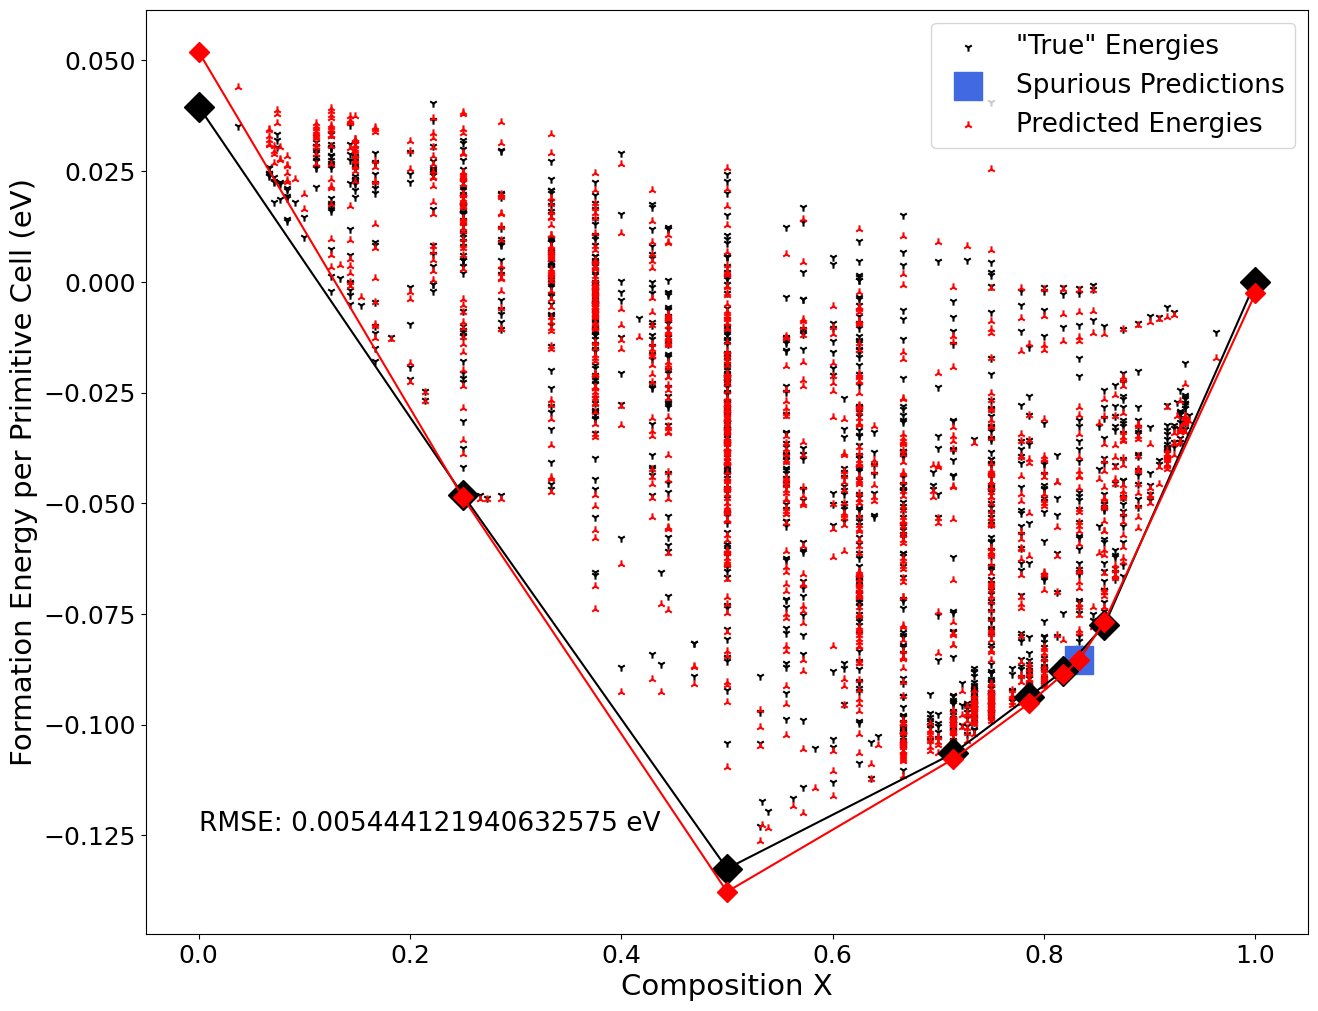

In [ ]:
#calculate predited formation energies for the max_gsa_model, and display the convex hull 
max_gsa_model_predicted_energies = corr_nonzero @ max_gsa_model
max_gsa_model_predicted_energies_full = corr_full_nonzero @ max_gsa_model

fig = general_binary_convex_hull_plotter(composition=comp, true_energies=formation_energy, predicted_energies=max_gsa_model_predicted_energies)


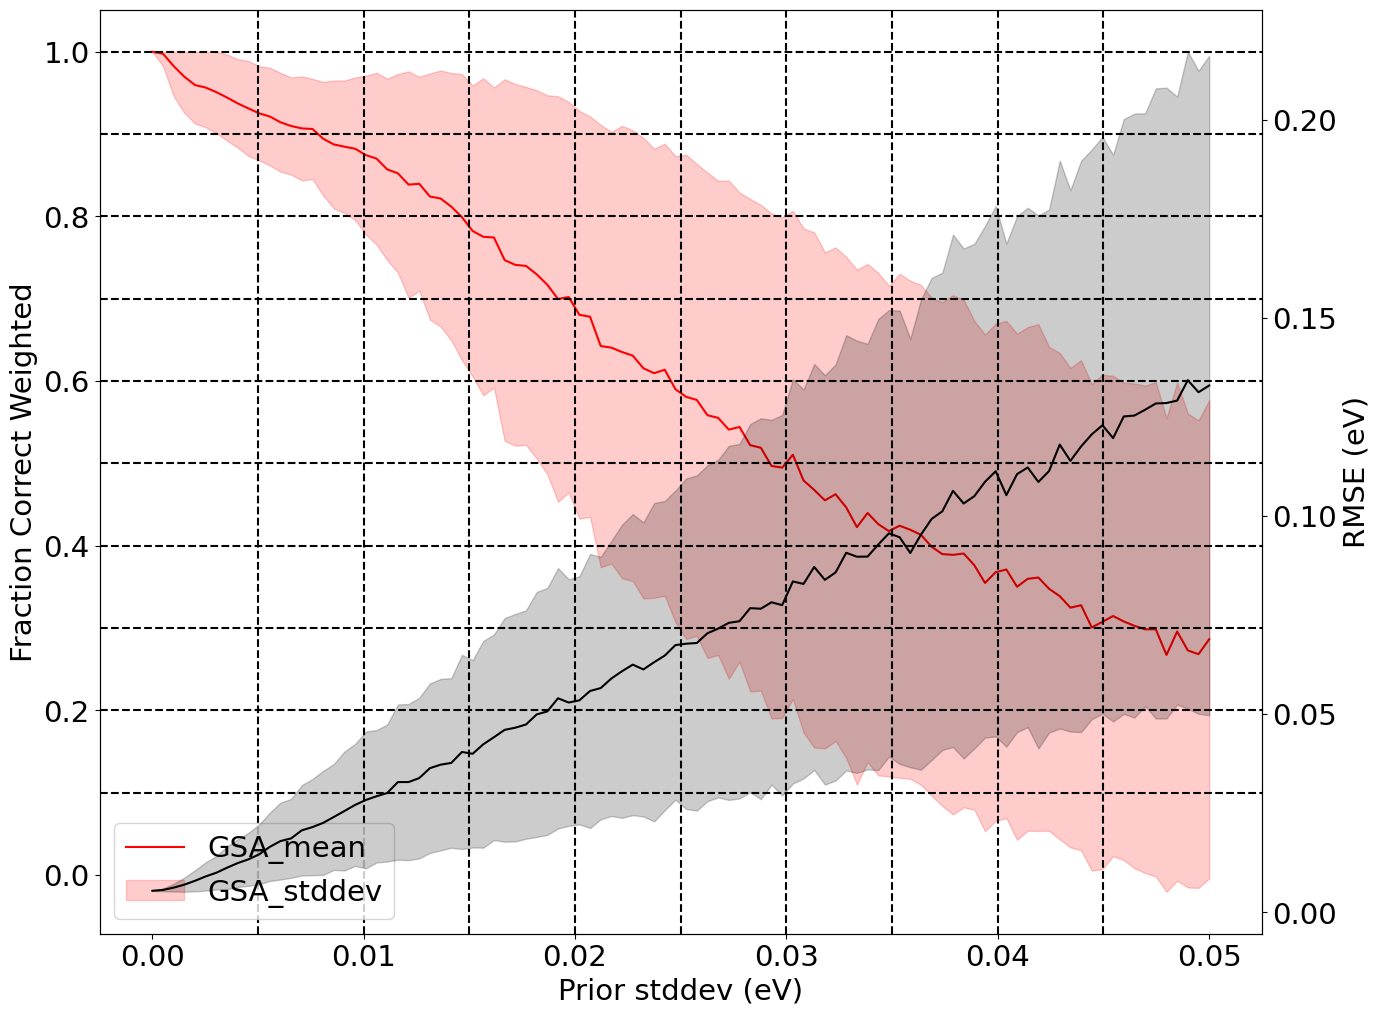

In [ ]:
#Visualize the ground state accuracy and RMSE statistics as a function of the prior variance. 


top_bound = np.array(prior_data["fraction_correct_weighted_means"]) + np.array(prior_data["fraction_correct_weighted_stddevs"])
#If any of the top bounds are greater than 1, set them equal to 1
top_bound[top_bound > 1] = 1

plt.plot(prior_data["eci_stddev_values"], prior_data["fraction_correct_weighted_means"], color='r')
plt.fill_between(prior_data["eci_stddev_values"], 
                 np.array(prior_data["fraction_correct_weighted_means"]) - np.array(prior_data["fraction_correct_weighted_stddevs"]), 
                 top_bound, 
                 color='r', 
                 alpha=0.2)
plt.xlabel('Prior stddev (eV)', fontsize=21)
plt.ylabel('Fraction Correct Weighted', fontsize=21)
plt.xticks(fontsize=21)
plt.yticks(fontsize=21)
plt.legend([ 'GSA_mean',"GSA_stddev"], fontsize=21)

#plot vertical lines at every 0.005 eV
for i in np.arange(0.005, 0.05, 0.005):
    plt.axvline(x=i, color='k', linestyle='--')




#plot horizontal lines at every 0.1 
for i in np.arange(0.1, 1.1, 0.1):
    plt.axhline(y=i, color='k', linestyle='--')



#Plot rmse on the same plot with a different y axis
ax2 = plt.gca().twinx()
ax2.plot(prior_data["eci_stddev_values"], prior_data["rmse_means"], color='k')
ax2.fill_between(prior_data["eci_stddev_values"], 
                 np.array(prior_data["rmse_means"]) - np.array(prior_data["rmse_stddevs"]), 
                 np.array(prior_data["rmse_means"]) + np.array(prior_data["rmse_stddevs"]), 
                 color='k', alpha=0.2)
#Label the second y axis 
ax2.set_ylabel('RMSE (eV)', fontsize=21)
ax2.tick_params(axis='y', labelcolor='k', labelsize=21)

    

fig = plt.gcf()
fig.set_size_inches(15,12)
plt.show()

In [87]:
#Find the prior stddev where the ground state accuracy mean - 1 stddev drops below 0.9
#This is the prior stddev that we will use for the final model
prior_stddev_90_percent = prior_data["eci_stddev_values"][np.where(np.array(prior_data["fraction_correct_weighted_means"]) - np.array(prior_data["fraction_correct_weighted_stddevs"]) < 0.9)[0][0]]
print(prior_stddev_90_percent)


0.005564444444444444


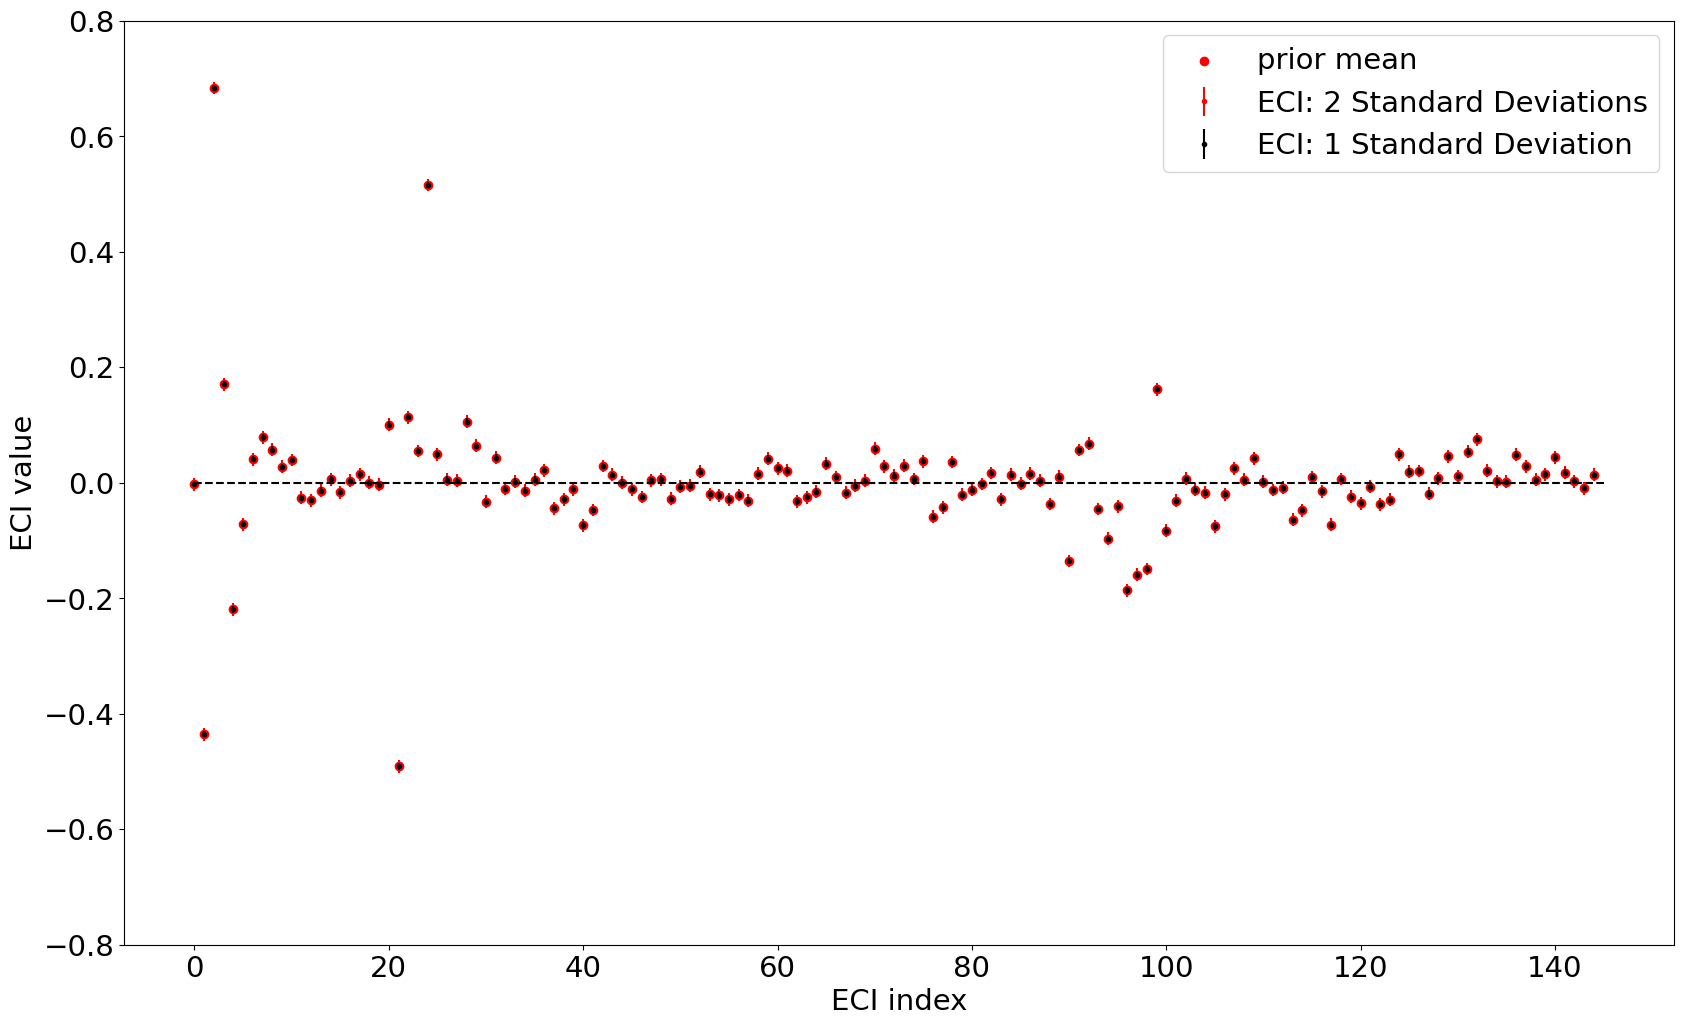

In [103]:
#Visualize the uncertainty in the posterior model



#If you happened to find a model with higher ground state accuracy, 
#try using the max gsa model as the mean instead of the max model (uncomment below)
prior_mean_nonzero = max_gsa_model


prior_covariance = prior_stddev_90_percent ** 2 * np.identity(prior_mean_nonzero.shape[0])

plt.errorbar(x=list(range(len(prior_mean_nonzero))),
    y=prior_mean_nonzero,
    yerr=2*np.power(np.diag(prior_covariance),.5),
    fmt='.',
    color='r',
    label='ECI: 2 Standard Deviations')
plt.errorbar(x=list(range(len(prior_mean_nonzero))),
    y=prior_mean_nonzero,  
    yerr=np.power(np.diag(prior_covariance),.5), 
    fmt='.', 
    color='k', 
    label='ECI: 1 Standard Deviation')
plt.scatter(list(range(len(prior_mean_nonzero))), prior_mean_nonzero, color='r', label='prior mean')
plt.ylim([-.8,0.8])
plt.hlines(y=0, xmin=0, xmax=len(prior_mean_nonzero), linestyles='--', color='k')
plt.legend(fontsize=21)
plt.xticks(fontsize=21)
plt.yticks(fontsize=21)
plt.xlabel('ECI index', fontsize=21)
plt.ylabel('ECI value', fontsize=21)
fig = plt.gcf()
fig.set_size_inches(20,12)
plt.show()

In [104]:
#Calculate the posterior given the prior selected by sampling 
max_gsa_model_covariance = prior_stddev_90_percent ** 2 * np.identity(prior_mean_nonzero.shape[0])
likelihood_covariance = np.eye(corr_nonzero.shape[0]) * likelihood_stddev**2
max_gsa_model_posterior_mean, max_gsa_model_posterior_covariance = dj.analytic_posterior(feature_matrix =corr_nonzero, 
                                                                                         weight_mean_vec=max_gsa_model,
                                                                                        weight_covariance_matrix=max_gsa_model_covariance, 
                                                                                        label_vec=formation_energy, 
                                                                                        label_covariance_matrix=likelihood_covariance)

In [105]:
#Calculate the ground state accuracy of the posterior model 
posterior_gsa = cl.gsa_fraction_correct_DFT_mu_window_binary(predicted_comp=comp_full, 
                                                             predicted_energies=corr_full_nonzero @ max_gsa_model_posterior_mean, 
                                                             predicted_corr=corr_full_nonzero, 
                                                             true_comp=comp, 
                                                             true_energies=formation_energy, 
                                                             true_corr=corr_nonzero)
print(posterior_gsa)

0.905293590875201


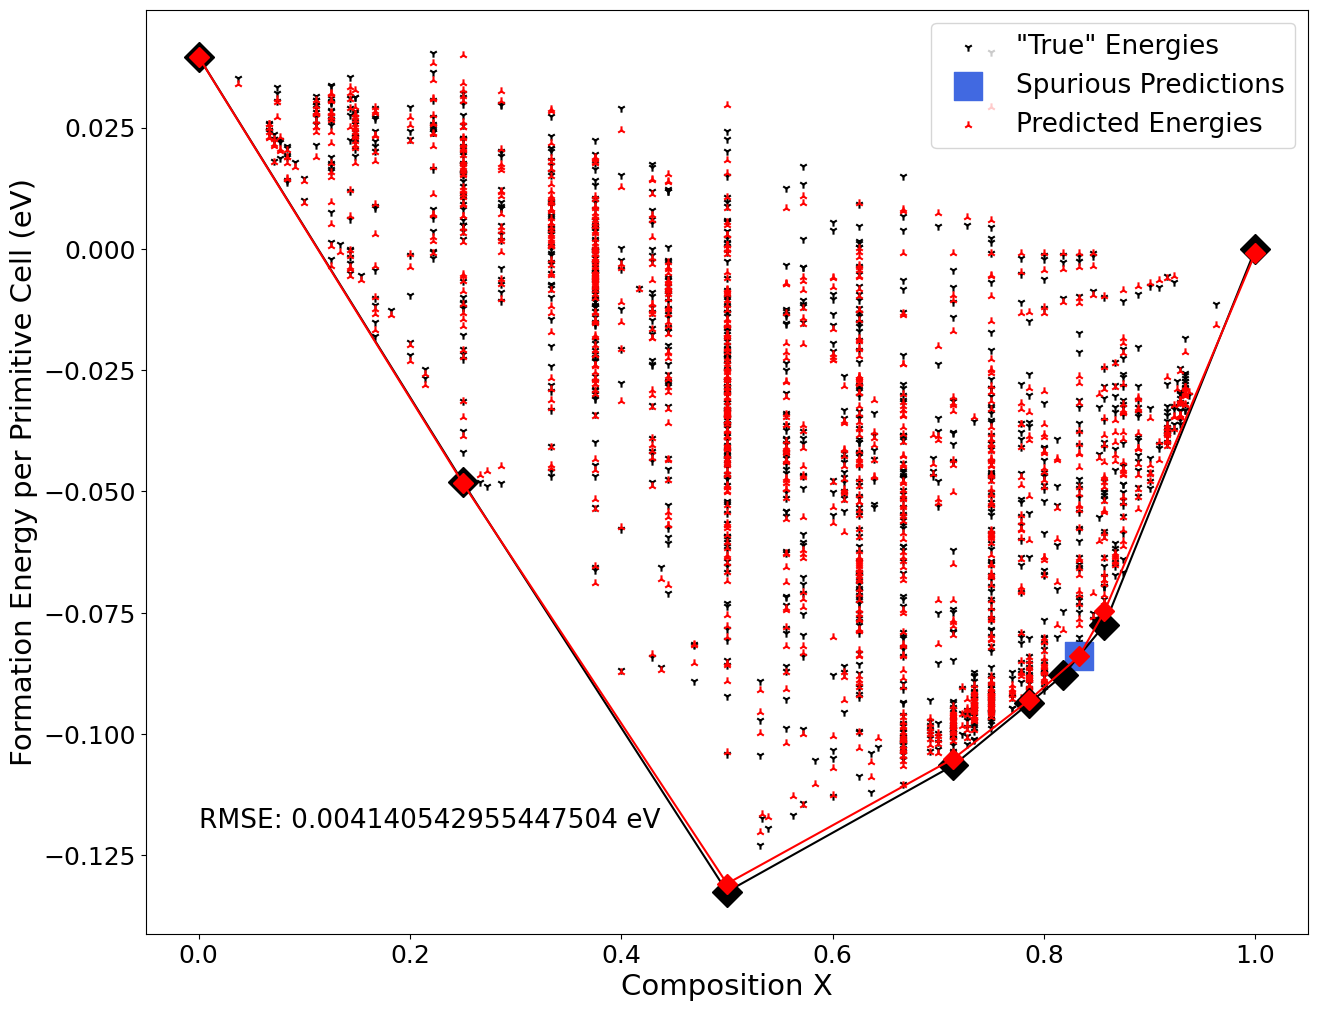

In [106]:
#visualize the convex hull of the posterior model
max_gsa_model_posterior_predicted_energies = corr_nonzero @ max_gsa_model_posterior_mean
fig = general_binary_convex_hull_plotter(composition=comp, true_energies=formation_energy, predicted_energies=max_gsa_model_posterior_predicted_energies)

In [107]:
#Write the posterior mean, posterior covariance and upscaling vector to a json file
with open('posterior_data.json', 'w') as f:
    json.dump({'posterior_mean':max_gsa_model_posterior_mean.tolist(), 
               'posterior_covariance':max_gsa_model_posterior_covariance.tolist(), 
               'upscaling_vector':zeroed_upscaling_boolean_vector.tolist()}, f)

In [ ]:
#NOTE: below code is not updated to work with the new ground state fraction correct weighted metric. Will be updated this week. 

In [ ]:
#Another way to select the prior stddev is to select the prior stddev that maximizes the posterior ground state accuracy


#calculate posterior means for each value of the prior standard deviation
posterior_means = []
for index, eci_stddev in enumerate(eci_stddev_values):
    prior_covariance = np.eye(prior_mean_nonzero.shape[0]) * eci_stddev**2
    likelihood_covariance = np.eye(corr_nonzero.shape[0]) * likelihood_stddev**2
    posterior_mean, posterior_covariance = dj.analytic_posterior(feature_matrix=corr_nonzero,
    weight_covariance_matrix=prior_covariance,
    weight_mean_vec=prior_mean_nonzero, 
    label_vec=formation_energy, 
    label_covariance_matrix=likelihood_covariance)
    posterior_means.append(posterior_mean)

posterior_means = np.array(posterior_means)

In [ ]:
#For each row in the predicted energies array, compute: 
#rmse, ground_state_accuracy_metric, ground_state_fraction_correct, gsa_fraction_correct_DFT_mu_window_binary, gsa_intersection_over_union, complexity


print(posterior_means.shape)


#Calculate the predicted energies for each model 
posterior_predicted_energies = corr_nonzero @ posterior_means.T
posterior_predicted_energies = posterior_predicted_energies.T

posterior_predicted_energies_full_enumeration = corr_full_nonzero @ posterior_means.T
posterior_predicted_energies_full_enumeration = posterior_predicted_energies_full_enumeration.T

print(posterior_predicted_energies.shape)
print(posterior_predicted_energies_full_enumeration.shape)


posterior_rmse = []
posterior_fraction_correct_weighted_full_enumeration = []




for index, row in enumerate(posterior_predicted_energies_full_enumeration):
#    predicted_hull_full_enumeration = thull.full_hull(compositions=comp_full, energies=row)
#    predicted_lower_hull_vertices_full_enumeration, _ = thull.lower_hull(predicted_hull_full_enumeration)

    posterior_rmse.append(mean_squared_error(y_true=formation_energy,y_pred=posterior_predicted_energies[index],squared=False))


    posterior_fraction_correct_weighted_full_enumeration.append(
        cl.gsa_fraction_correct_DFT_mu_window_binary(predicted_comp=comp_full, 
                                                     predicted_energies=row,
                                                     predicted_corr=corr_full,
                                                     true_comp=comp,
                                                     true_energies=formation_energy,
                                                     true_corr=corr)
        )
posterior_fraction_correct_weighted_full_enumeration = np.array(posterior_fraction_correct_weighted_full_enumeration)
posterior_rmse = np.array(posterior_rmse)

print(posterior_fraction_correct_weighted_full_enumeration.shape)




#Get all predicted energies for each row in posterior means
predicted_energies = corr_nonzero @ posterior_means.T
predicted_energies = predicted_energies.T

#For each row in posterior means, calculate all ground state accuracy metrics and rmse as a function of eci_stddev_values
gsa = []
gsf = []
gsad = []
gsu = []
rmse = []
for row in predicted_energies:
    predicted_hull = thull.full_hull(compositions=comp, energies=row)
    predicted_lower_hull_vertices, _ = thull.lower_hull(predicted_hull)

    #calculate the rmse
    rmse.append(np.sqrt(mean_squared_error(formation_energy, row)))
    #calculate the ground state accuracy metric
    gsa.append(cl.ground_state_accuracy_metric(comp, row, true_lower_hull_vertices))
    #calculate the ground state fraction correct
    gsf.append(cl.ground_state_accuracy_fraction_correct(predicted_lower_hull_vertices, true_lower_hull_vertices))
    #calculate the ground state accuracy metric with a DFT mu window
    gsad.append(cl.gsa_fraction_correct_DFT_mu_window_binary(comp, row, comp, formation_energy))
    #calculate the ground state intersection over union
    gsu.append(cl.gsa_fraction_intersection_over_union(predicted_lower_hull_vertices, true_lower_hull_vertices))

#Place all of the metrics into a dataframe
import pandas as pd
df = pd.DataFrame({'rmse':rmse, 'gsa':gsa, 'gsf':gsf, 'gsad':gsad, 'gsu':gsu})
df['eci_stddev'] = eci_stddev_values

In [ ]:
#Plot all of the metrics vs eci_stddev

fig, ax = plt.subplots(1, 1, figsize=(20, 12))
#ax.plot(eci_stddev, posterior_rmse, label='rmse')
ax.plot(eci_stddev_values, (1-np.array(posterior_rmse)/max_rmse_tolerance), label='rmse-based accuracy metric')
ax.plot(eci_stddev_values, posterior_fraction_correct_weighted_full_enumeration, label='')
ax.set_xlabel('eci_stddev', fontsize=21)
ax.set_ylabel('metric', fontsize=21)
ax.legend(fontsize=21, loc='lower right')
plt.xticks(fontsize=21)
plt.yticks(fontsize=21)
plt.ylim([0,1])
plt.show()

In [ ]:
#Plot the product of all of the metrics vs eci_stddev
posterior_product =   posterior_fraction_correct_weighted_full_enumeration *(1-np.array(posterior_rmse)/max_rmse_tolerance)
fig, ax = plt.subplots(1, 1, figsize=(20, 12))
ax.plot(eci_stddev_values, posterior_product, label='product')
ax.set_xlabel('eci_stddev', fontsize=21)
ax.set_ylabel('product', fontsize=21)
ax.legend(fontsize=21)
plt.xticks(fontsize=21)
plt.yticks(fontsize=21)
plt.show()

In [ ]:
#Find the argmax of the product, find the corresponding eci_stddev
optimal_eci_stddev = np.argmax(posterior_product)
print(eci_stddev_values[optimal_eci_stddev])

In [ ]:
#Calculate the posterior distribution using the optimal eci_stddev
prior_covariance = np.eye(prior_mean_nonzero.shape[0]) * df['eci_stddev'][optimal_eci_stddev]**2
likelihood_covariance = np.eye(corr_nonzero.shape[0]) * likelihood_stddev**2
posterior_mean, posterior_covariance = dj.analytic_posterior(feature_matrix=corr_nonzero, 
weight_covariance_matrix=prior_covariance,
weight_mean_vec=prior_mean_nonzero, 
label_vec=formation_energy, 
label_covariance_matrix=likelihood_covariance)

In [ ]:
#Visualize the posterior mean model
fig = general_binary_convex_hull_plotter(composition=comp, true_energies=formation_energy, predicted_energies=corr_nonzero@posterior_mean)
plt.show()

In [ ]:
#Visualize the uncertainty in the posterior model
plt.errorbar(x=list(range(len(posterior_mean))),
    y=posterior_mean,
    yerr=2*np.power(np.diag(posterior_covariance),.5),
    fmt='.',
    color='r',
    label='ECI: 2 Standard Deviations')
plt.errorbar(x=list(range(len(posterior_mean))),
    y=posterior_mean,  
    yerr=np.power(np.diag(posterior_covariance),.5), 
    fmt='.', 
    color='k', 
    label='ECI: 1 Standard Deviation')
plt.scatter(list(range(len(posterior_mean))), posterior_mean, color='r', label='posterior mean')
plt.ylim([-.8,0.8])
plt.hlines(y=0, xmin=0, xmax=len(posterior_mean), linestyles='--', color='k')
plt.legend(fontsize=21)
plt.xticks(fontsize=21)
plt.yticks(fontsize=21)
plt.xlabel('ECI index', fontsize=21)
plt.ylabel('ECI value', fontsize=21)
fig = plt.gcf()
fig.set_size_inches(20,12)
plt.show()

In [ ]:
#Write the posterior mean, posterior covariance matrix and upscaling vector to a json file
import json
with open('posterior_mean_weighted_LS_with_hullcorr.json', 'w') as f:
    write_dict = {}
    write_dict['posterior_mean'] = posterior_mean.tolist()
    write_dict['posterior_covariance'] = posterior_covariance.tolist()
    write_dict['upscaling_vector'] = zeroed_upscaling_boolean_vector.tolist()
    json.dump(write_dict, f)

